In [589]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from collections import defaultdict
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import the code from Afresh

In [2]:
# Clearly, this problem needs order_cost < under_order_cost , otherwise we’ll never order cereal.

## TODO: MYPY!

def get_cost(inventory, order, order_cost= 2, over_order_cost=4, under_order_cost=5):
    over_order_cost = max(inventory, 0) * over_order_cost
    under_order_cost = -min(inventory, 0) * under_order_cost
    return over_order_cost + under_order_cost + order * order_cost

def act_and_get_cost(inventory, order, demand):
    # possibly negative  
    resulting_inventory = inventory + order - demand
    cost = get_cost(inventory, order)
    next_inventory = max(resulting_inventory, 0)
    return next_inventory, cost

In [3]:
act_and_get_cost(10, 5, 1)

(14, 50)

In [4]:


class NonPerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost

    def act(self, state: float, shipment: float, sales: float) -> Tuple[float, float]:
        resulting_state = state + shipment - sales
        cost = self.cost_function(resulting_state, shipment)
        resulting_state = max(resulting_state, 0)
        return resulting_state, cost
    
    def dp_solve(self, forecasts: np.array, verbose: bool = False):
        T = forecasts.shape[0] # these are days
        max_order = forecasts.shape[1] # forecasts are the probability of that order being made, each col is an order amount
        print(max_order, 'max_order')
        
        inventory_max = max_order * (T + 1)
        print(inventory_max, 'inventory_max')
        inventory_max_opt = max_order * T
        print(inventory_max_opt, 'inventory_max_opt')
        
        matrix_size = (T + 1, inventory_max) 
        matrix_size_opt = (T, inventory_max)
        
        explain_array = np.zeros((T, inventory_max, max_order))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size_opt, np.inf)
        # cost_array[-1, :] = 0 # cost of the initial state is 0
        
        for t in range(T - 1, -1, -1):
            print(t, 'T')
            for inv in range(inventory_max_opt):
                if verbose:
                    print(inv,' inventory')
                best_order = -1
                best_cost = np.inf
                for order in range(max_order):
                    cost = 0
                    if verbose:
                        print(order, 'order')
                    for forecast in range(max_order): #
                        
                        forecast_prob = forecasts[t, forecast]

                        # forecast here is used as shipment
                        state, prob_cost = self.act(inv, order, forecast)
                        if t+1 == T:
                            resultant_cost = 0
                        else:
                            resultant_cost = cost_array[t + 1, state] #this is the terminal cost for this state, we accumulate this through days based upon the inventory levels present
                        
                        # prob cost is the cost of the forecast of a given amount of demand
                        # resultant cost is looking at the previous days cost given this amount of inventory
                        cost += forecast_prob * (prob_cost + resultant_cost)
                        if verbose:
                            print(state, prob_cost, 'state, prob_cost')
                            print(forecast, 'forecast')
                            print(forecast, 'forecast')
                            print(forecast_prob, 'forecast_prob')
                            print(resultant_cost, 'resultant_cost')
                            print(cost,'cost')
                            print('---')
                    explain_array[t, inv, order] = cost
                    if cost < best_cost:
                        best_cost = cost
                        best_order = order
                path_array[t, inv] = best_order
                cost_array[t, inv] = best_cost
        return explain_array, path_array, cost_array

In [5]:
# 2 days of forecasts, 5 possible values
forecasts_unnormalized = np.random.random((2, 5))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver =  NonPerishableDPSolver(over_order_cost=2,under_order_cost= 6, fixed_order_cost=0)

In [6]:
# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts, verbose=True)

5 max_order
15 inventory_max
10 inventory_max_opt
1 T
0  inventory
0 order
0 0 state, prob_cost
0 forecast
0 forecast
0.16670195619583092 forecast_prob
0 resultant_cost
0.0 cost
---
0 6 state, prob_cost
1 forecast
1 forecast
0.07867534294533543 forecast_prob
0 resultant_cost
0.4720520576720126 cost
---
0 12 state, prob_cost
2 forecast
2 forecast
0.2432148989933493 forecast_prob
0 resultant_cost
3.390630845592204 cost
---
0 18 state, prob_cost
3 forecast
3 forecast
0.26726055972856066 forecast_prob
0 resultant_cost
8.201320920706296 cost
---
0 24 state, prob_cost
4 forecast
4 forecast
0.2441472421369237 forecast_prob
0 resultant_cost
14.060854731992464 cost
---
1 order
1 2 state, prob_cost
0 forecast
0 forecast
0.16670195619583092 forecast_prob
0 resultant_cost
0.33340391239166184 cost
---
0 0 state, prob_cost
1 forecast
1 forecast
0.07867534294533543 forecast_prob
0 resultant_cost
0.33340391239166184 cost
---
0 6 state, prob_cost
2 forecast
2 forecast
0.2432148989933493 forecast_prob
0

In [7]:
# 10 days of forecasts, 15 possible values
forecasts_unnormalized = np.random.random((10, 15))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver = NonPerishableDPSolver(over_order_cost=2,under_order_cost= 6, fixed_order_cost=0)

# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts)

15 max_order
165 inventory_max
150 inventory_max_opt
9 T
8 T
7 T
6 T
5 T
4 T
3 T
2 T
1 T
0 T


In [8]:
cost_array.shape # why is there 11 here?

(10, 165)

In [9]:
forecasts.shape

(10, 15)

In [10]:
path_array.shape

(11, 165)

In [11]:
explain_array.shape

(10, 165, 15)

## Forecasts

In [12]:
forecasts

array([[0.11470036, 0.08230898, 0.047894  , 0.00844378, 0.0758067 ,
        0.15276807, 0.05155964, 0.13567521, 0.07267368, 0.05691848,
        0.0002982 , 0.02246573, 0.02042451, 0.08964583, 0.06841683],
       [0.05238299, 0.07069908, 0.00739053, 0.12147683, 0.06644222,
        0.11365385, 0.06337243, 0.09590258, 0.05512111, 0.01202392,
        0.13625556, 0.05254615, 0.05973766, 0.03510006, 0.05789502],
       [0.05658786, 0.00116822, 0.03544576, 0.12841787, 0.01346434,
        0.06625468, 0.12902688, 0.11257428, 0.00774579, 0.02115949,
        0.10281386, 0.10439757, 0.01734789, 0.11322408, 0.09037142],
       [0.10337156, 0.01396033, 0.07260766, 0.03192267, 0.12633822,
        0.00351002, 0.00406939, 0.08853895, 0.09266197, 0.12489877,
        0.06119415, 0.03762171, 0.13345873, 0.02817539, 0.07767048],
       [0.03679958, 0.06014092, 0.05090125, 0.00147874, 0.14533404,
        0.14311587, 0.12164841, 0.04874133, 0.00549783, 0.00784574,
        0.08846326, 0.11428137, 0.09861053, 

Text(0.5, 0.98, 'Inventory Count at time zero')

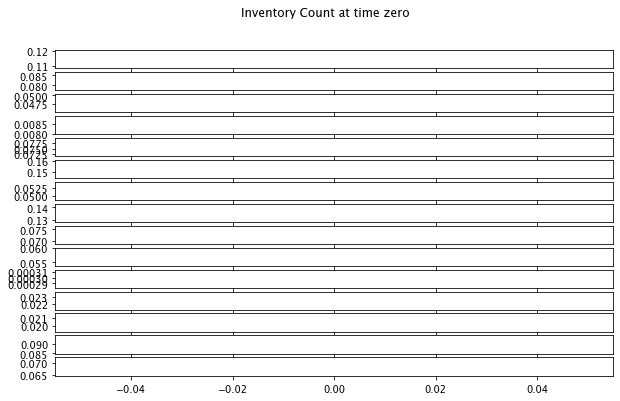

In [13]:
fig, ax = plt.subplots( len(forecasts[0,:]), squeeze=True, figsize=(10,6))

for inventory_count in range(len(forecasts[0, :])): # x is day, y is inventory
    ax[inventory_count].plot(forecasts[0, inventory_count])
fig.suptitle('Inventory Count at time zero') 

    



## Cost

In [14]:
cost_array

array([[107.7711336 , 107.7711336 , 107.7711336 , ...,          inf,
                 inf,          inf],
       [ 95.79710052,  95.79710052,  95.79710052, ...,          inf,
                 inf,          inf],
       [ 85.34375022,  85.34375022,  85.34375022, ...,          inf,
                 inf,          inf],
       ...,
       [ 33.16339274,  33.16339274,  33.16339274, ...,          inf,
                 inf,          inf],
       [ 22.61632798,  22.61632798,  22.61632798, ...,          inf,
                 inf,          inf],
       [ 10.25654607,  10.25654607,  10.25654607, ...,          inf,
                 inf,          inf]])

In [15]:
cost_array[-1, :50]

array([10.25654607, 10.25654607, 10.25654607, 10.25654607, 10.25654607,
       10.25654607, 10.25654607, 10.25654607, 10.25654607, 10.25654607,
       10.25654607, 10.25654607, 10.25654607, 10.86691791, 11.98521173,
       13.98521173, 15.98521173, 17.98521173, 19.98521173, 21.98521173,
       23.98521173, 25.98521173, 27.98521173, 29.98521173, 31.98521173,
       33.98521173, 35.98521173, 37.98521173, 39.98521173, 41.98521173,
       43.98521173, 45.98521173, 47.98521173, 49.98521173, 51.98521173,
       53.98521173, 55.98521173, 57.98521173, 59.98521173, 61.98521173,
       63.98521173, 65.98521173, 67.98521173, 69.98521173, 71.98521173,
       73.98521173, 75.98521173, 77.98521173, 79.98521173, 81.98521173])

Text(0, 0.5, 'cost')

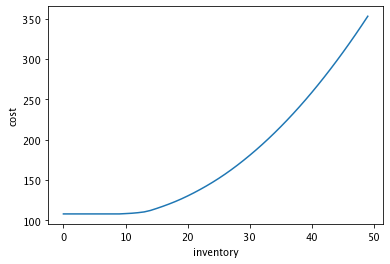

In [16]:
plt.plot(cost_array[0, :50])
plt.xlabel('inventory')

plt.ylabel('cost')

Text(0.5, 0.98, 'Cost per day. each plot is a day, x axis is cost')

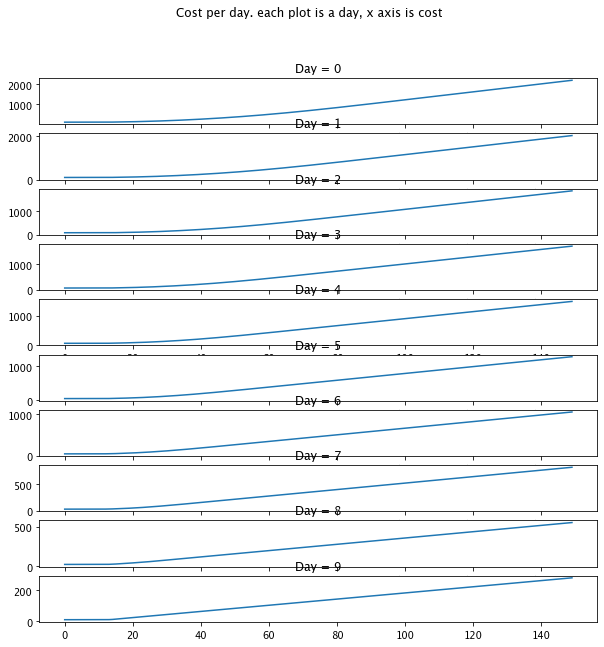

In [17]:
n_days =  cost_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(cost_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Cost per day. each plot is a day, x axis is cost') 
    



In [18]:
## at T=

### Path

In [19]:
path_array.shape

(11, 165)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

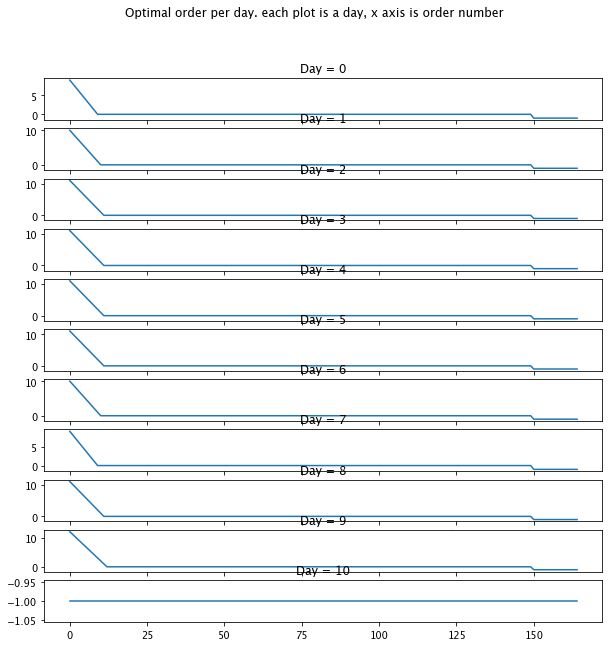

In [20]:
n_days =  path_array.shape[0]
fig, ax = plt.subplots(n_days, squeeze=True, figsize=(10,10)) # x axis is day, y axis is inventory

for day_n in range(n_days):
    ax[day_n].plot(path_array[day_n, :])
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[day_n].set_title(f"Day = {day_n}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



## Path vs Cost

### Explain Array

In [21]:
explain_array.shape # Time, Inventory, Order

(10, 165, 15)

Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

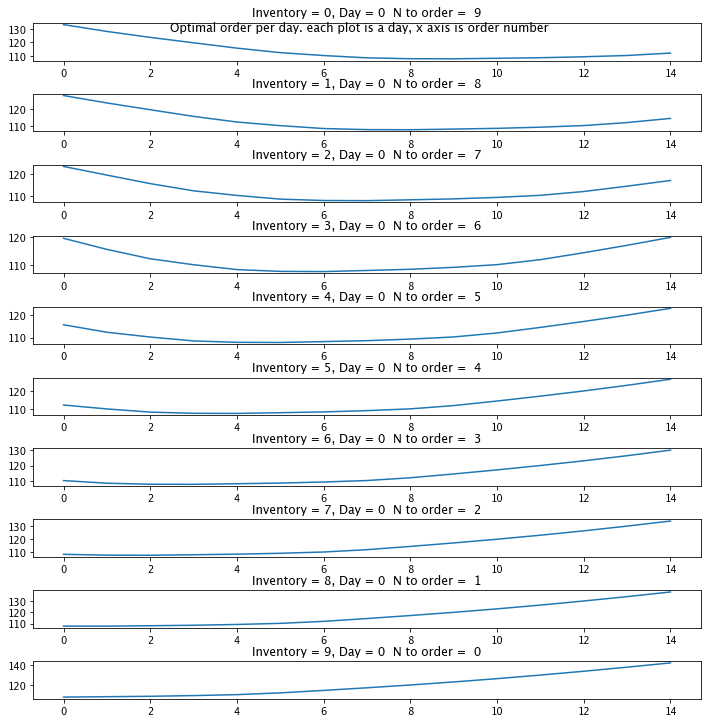

In [22]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 0
fig, ax = plt.subplots(inventory_n, figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [23]:
print("For day T=0, we want to have a total of 10 items")

For day T=0, we want to have a total of 10 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

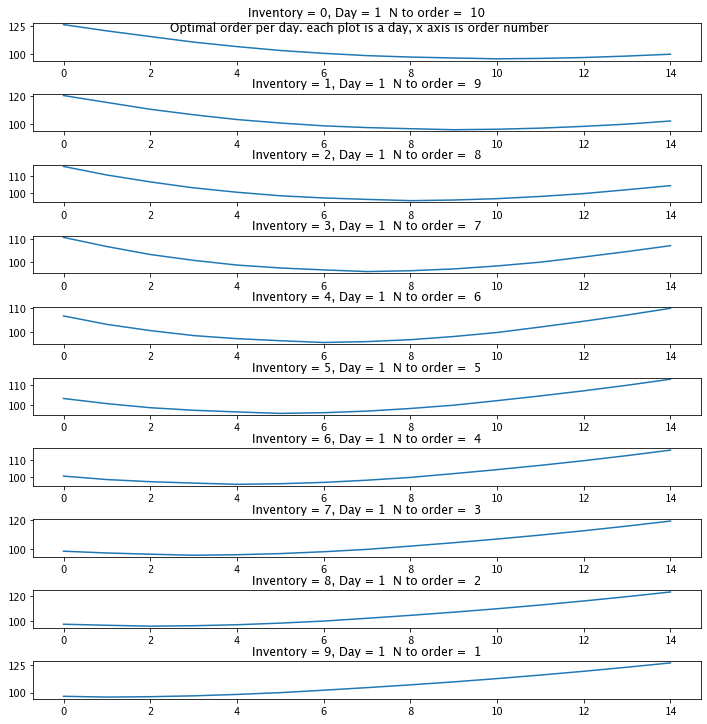

In [24]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 1
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [25]:
print("For day T=1, we want to have a total of 10 items")

For day T=1, we want to have a total of 10 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

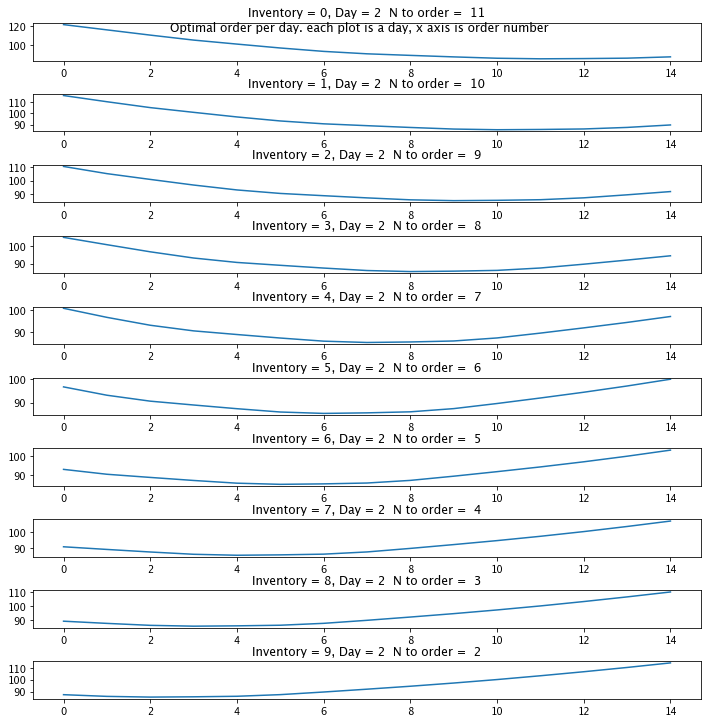

In [26]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 2
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [27]:
print("For day T=12 we want to have a total of 11 items")

For day T=12 we want to have a total of 11 items


Text(0.5, 0.98, 'Optimal order per day. each plot is a day, x axis is order number')

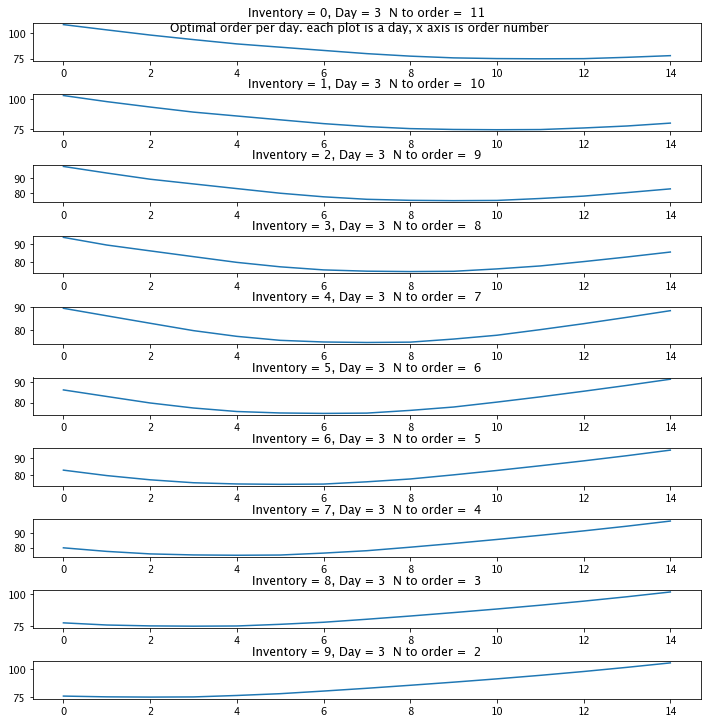

In [28]:
inventory_n =  10
n_orders = np.arange(explain_array.shape[2])
day_n = 3
fig, ax = plt.subplots(inventory_n,  figsize=(10,10)) # x axis is day, y axis is inventory
fig.tight_layout()

for inventory in range(inventory_n):
    ax[inventory].plot(explain_array[day_n, inventory, :]) # Time, Inventory, Order
    # print(f" N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")
    # ax[inventory_count].set_ax(f'Inventory Count: { inventory_count}')
    ax[inventory].set_title(f"Inventory = {inventory}, Day = {day_n}  N to order =  {n_orders[np.argmin(explain_array[day_n, inventory, :])]}")

fig.suptitle('Optimal order per day. each plot is a day, x axis is order number') 
    



In [29]:
print("For day T=3 we want to have a total of 12 items")

For day T=3 we want to have a total of 12 items


# Add blueberries

In [651]:


def get_sales(state: np.array, total_sales: int, max_age: int) -> int:
    """Given total_sales, allocate them in a FIFO manner"""
    # state is vector of blueberry ages
    total_sales = total_sales
    for i in range(max_age-1, -1, -1):
        try:
            sale = min(state[i], total_sales) # can sell more than what is in nstock
        except Exception as e:
            print(sale, 'sale')
            print(total_sales, 'total_sales')
            print(state, 'state')
            print(e)
        total_sales -= sale # allocate sales accroding to age
        state[i] = state[i] - sale
    return total_sales, state # lost sales


def transition(state: np.array, max_age: int) -> Tuple[int, np.array]:
    """Every item of age k ages into k+1, oldest items go to
    waste"""
    
    ## TODO: markov matrix here
    last = 0
    tmp = 0
    for i in range(max_age):
        tmp = state[i]
        state[i] = last
        last = tmp
    return last, state # waste, updated state


def act(state, shipment, sales, max_age):
    "Given a shipment and sales, transform the state"
    state[0] = shipment # shipmennts are fresh blueberries, go into the first age col
    print(state, ' state after update with shipment')
    print(sales, 'sales')
    lost_sales, updated_with_sales_state = get_sales(state, sales, max_age)
    print(updated_with_sales_state, 'updated_with_sales_state r emoving sales from blueberry inventory')
    print(lost_sales, 'lost_sales')
    waste, updated_with_transition_state = transition(updated_with_sales_state, max_age)
    
    total_lost_sales = lost_sales + waste
    

    # cost = self.cost_function(total_lost_sales, shipment) # add in as part of the class
    cost = 0 
    
    resulting_state = int(np.sum(updated_with_transition_state))
    
    # resulting_state should be the level of inventory we have left
    
    return resulting_state, cost, updated_with_transition_state

In [652]:
max_age = 5
max_inventory = 3

blueberry_vector = [2,2,0,1,2]
total_sales=3

In [653]:
assert get_sales(blueberry_vector, total_sales ,max_age)  == (0, [2,2,0,0, 0])
assert transition(blueberry_vector, max_age) == (0, [0, 2, 2, 0, 0])

In [142]:
max_age = 5
max_inventory = 3

blueberry_vector = [2,2,0,1,2]
total_sales=15
shipment=5

In [143]:
act(blueberry_vector, shipment, total_sales, max_age)

[5, 2, 0, 1, 2]  state after update with shipment
15 sales
[0, 0, 0, 0, 0] updated_with_sales_state r emoving sales from blueberry inventory
5 lost_sales


(0, 0, [0, 0, 0, 0, 0])

In [33]:
act(blueberry_vector, shipment=2, sales=1)

Lost sales = 1, Waste = 0
State = [0 2 2 1 2]


In [716]:


class PerishableDPSolver:
    def __init__(self,
                 over_order_cost: float,
                 under_order_cost: float,
                 fixed_order_cost: float,
                 max_age: float):
        self.over_order_cost = over_order_cost
        self.under_order_cost = under_order_cost
        self.fixed_order_cost = fixed_order_cost
        self.max_age = max_age

    def cost_function(self, state, order):
        over_order_cost = max(state, 0) * self.over_order_cost
        under_order_cost = -min(state, 0) * self.under_order_cost
        order_cost = self.fixed_order_cost * order
        return over_order_cost + under_order_cost + order_cost
    
    

    
    
    def get_sales(self, state: np.array, total_sales: int, max_age: int) -> int:
        """Given total_sales, allocate them in a FIFO manner"""
        # state is vector of blueberry ages
        total_sales = total_sales
        for i in range(max_age-1, -1, -1):
            sale = min(state[i], total_sales) # can sell more than what is in nstock
            total_sales -= sale # allocate sales accroding to age
            state[i] = state[i] - sale
        return total_sales, state # lost sales

    
    
    def transition(self, state: np.array, max_age: int) -> Tuple[int, np.array]:
        """Every item of age k ages into k+1, oldest items go to
        waste"""
        
        ## TODO: markov matrix here
        last = 0
        tmp = 0
        for i in range(max_age):
            tmp = state[i]
            state[i] = last
            last = tmp
        return last, state # waste, updated state

    
    def act(self, state, shipment, sales, max_age, verbose=False):
        "Given a shipment and sales, transform the state"
        try:
            state[0] += shipment # shipmennts are fresh blueberries, go into the first age col
        except Exception as e:
            print(e, state, 'e state')
        
        if verbose:
            print(state, ' state after update with shipment')
            print(sales, 'sales')
        lost_sales, updated_with_sales_state = self.get_sales(state, sales, max_age)
        
        if verbose:
            print(updated_with_sales_state, 'updated_with_sales_state r emoving sales from blueberry inventory')
            print(lost_sales, 'lost_sales')
        waste, updated_with_transition_state = self.transition(updated_with_sales_state, max_age)
        
        total_lost_sales = lost_sales + waste
        

        cost = self.cost_function(total_lost_sales, shipment)
        
        resulting_state = int(np.sum(updated_with_transition_state))
        
        # resulting_state should be the level of inventory we have left
        
        return resulting_state, cost, updated_with_transition_state
        
    
    
    def dp_solve(self, forecasts: np.array, verbose: bool = False):
        T = forecasts.shape[0] # these are days
        max_order = forecasts.shape[1] # forecasts are the probability of that order being made, each col is an order amount
        print(max_order, 'max_order')
        
        inventory_max = max_order * (T + 1) 
        print(inventory_max, 'inventory_max')
        inventory_max_opt = max_order * T
        print(inventory_max_opt, 'inventory_max_opt')
        
        matrix_size = (T + 1, inventory_max, self.max_age)
        # matrix_size_opt = (T, inventory_max)
        
        explain_array = np.zeros((T + 1, inventory_max, max_order, self.max_age))
        path_array = np.full(matrix_size, -1, dtype=np.int32)
        cost_array = np.full(matrix_size, np.inf, dtype=np.float32)
        cost_array[-1, :] = 0 # cost of the initial state is 0
        blueberry_vector_dict =  defaultdict(list) #np.zeros((T + 1, inventory_max, max_order, self.max_age))
        
        for t in range(T - 1, -1, -1):
            print(t, 'T')
                

            for shelf_life in range(1, self.max_age+1):
                
                for inv in range(inventory_max_opt):
                    if verbose:
                        print(inv,' inventory')
                    
                    print(shelf_life, 'shelf_life')
                    best_order = -1
                    best_cost = np.inf
                    
                    # assume inventory is all old bluberries
                    blueberry_state = np.zeros(shelf_life)
                    
                    # bring over inventory from previous day, first day no inventory

                    inv = 0
                    

                    # print(blueberry_state, 'blueberry_state before inv')
                    # # add inventory to the last slot, if we don't use it, it will be 0
                    # blueberry_state[-1] += inv
                    # original_blueberry_inv_state = blueberry_state.copy()
                        
                    for order in range(max_order):     # test different orders aganss the inventory  
                        cost = 0
                        if verbose:
                            print(order, 'order')
                            
                        if t == T - 1:
                            blueberry_state_lookup = np.zeros(shelf_life)
                        else:
                            blueberry_state_lookup  = blueberry_vector_dict[(t + 1, inv, order, shelf_life-1)]
                            

                        
                        
                        if len(blueberry_state_lookup) == 0:
                            blueberry_state_lookup = np.zeros(shelf_life)
                            print(t, 'T')
                            print(inv, 'inv')
                            print(t + 1, inv, order, shelf_life-1, "t + 1, inv, order, shelf_life-1)")
                            print(blueberry_state_lookup, 'blueberry_state_lookup zero')
                        # add inv to blueberry
                        blueberry_state_lookup[-1 ]+= inv
                        
                        
                        for forecast in range(max_order): #
                            
                            
                            
                            forecast_prob = forecasts[t, forecast]

                            # forecast here is used as shipment
                            state, prob_cost, blueberry_state = self.act(blueberry_state_lookup, order, forecast, shelf_life, verbose)
                            resultant_cost = cost_array[t + 1, state, shelf_life-1]
                            

                            
                            
                            # prob cost is the cost of the forecast of a given amount of demand
                            # resultant cost is looking at the previous days cost given this amount of inventory
                            cost += forecast_prob * (prob_cost + resultant_cost)

                            if verbose:
                                print(blueberry_vector_dict, 'blueberry_vector_dict')
                                print(blueberry_state, 'updated blueberry state')
                                print(state, prob_cost, 'state, prob_cost')
                                print(forecast, 'forecast')
                                print(forecast_prob, 'forecast_prob')
                                print(resultant_cost, 'resultant_cost')
                                print(state, prob_cost, 'state, prob_cost')
                                print(blueberry_state, 'blueberry_state best cost')   
                                print(cost,'cost')
                                print(order, 'order')
                                print(inv, 'inv')
                                print('---')
                                print('---')
                                
                            # inv = inv + state # update inventory to include the blueberry inventory
                            blueberry_vector_dict[(t, inv, order, shelf_life-1)] = blueberry_state
                        
                        explain_array[t, inv, order, shelf_life-1] = cost
                        if cost < best_cost:
                            best_cost = cost
                            best_order = order

                    path_array[t, inv, shelf_life-1] = best_order
                    cost_array[t, inv, shelf_life-1] = best_cost
        return explain_array, path_array, cost_array

In [717]:
# 5 days of forecasts, 5 possible values
forecasts_unnormalized = np.random.random((5, 5))
# Normalize to make probabilities:
# This is used for the percent of total inventory that is demanded
forecasts = forecasts_unnormalized / np.expand_dims(forecasts_unnormalized.sum(axis=1), 1)
# Solve
solver = PerishableDPSolver(over_order_cost=2,under_order_cost= 2, fixed_order_cost=1.75, max_age=3)

# path_array, optimal order in this state
# cost array, cost in this state
explain_array, path_array, cost_array = solver.dp_solve(forecasts, verbose=False)

5 max_order
30 inventory_max
25 inventory_max_opt
4 T
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
1 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
2 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_life
3 shelf_li

## See if we can explore the cost function here

In [718]:
explain_array #  np.zeros((T, inventory_max, max_order, self.max_age))

array([[[[20.4248975 , 20.31746419, 19.79232152],
         [20.80608079,         inf,         inf],
         [22.62770013,         inf,         inf],
         [25.26631038,         inf,         inf],
         [28.71652477,         inf,         inf]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        ...,

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.    

In [719]:
explain_array[0,0,:,:] #  np.zeros((T, inventory_max, max_order, self.max_age))

array([[20.4248975 , 20.31746419, 19.79232152],
       [20.80608079,         inf,         inf],
       [22.62770013,         inf,         inf],
       [25.26631038,         inf,         inf],
       [28.71652477,         inf,         inf]])

In [720]:
explain_array.shape #  np.zeros((T, inventory_max, max_order, self.max_age))

(6, 30, 5, 3)

In [721]:
explain_array[0, 0,  0,  2]

19.792321515515304

In [722]:
explain_array[0 ,10, 2, :]

array([0., 0., 0.])

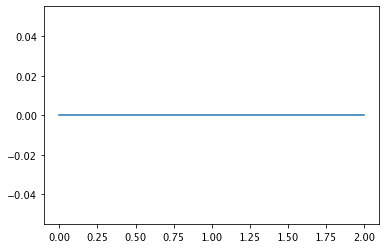

In [723]:
plt.plot(explain_array[0 ,1, 2, :]) # shelf life cost 10 inv 2 order

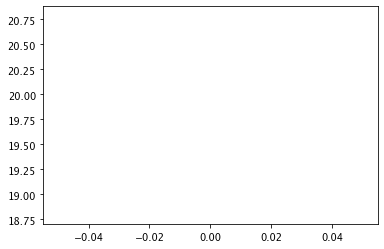

In [724]:
plt.plot(explain_array[0 ,0, :, 2]) # max order cost

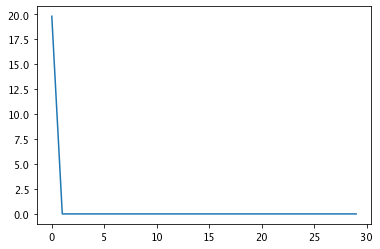

In [725]:
plt.plot(explain_array[0, :, 0, 2]) # inventory cost

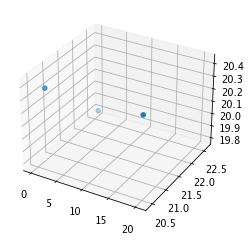

In [726]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(explain_array[0, :3, 0, 0], explain_array[0, 0,  :3, 0], explain_array[0, 0,  0,  :3], 'gray')

In [727]:
np.argmin(explain_array)

15

In [728]:
# day zero, no inventory, two days shelf life what is the best order?

explain_array[0, 0, :, 2]  #  np.zeros((T, inventory_max, max_order, self.max_age))

array([19.79232152,         inf,         inf,         inf,         inf])

In [729]:
explain_array[0, 0, :, 1]  # day zero, 0 inventory, one days shelf life what is the best order?

array([20.31746419,         inf,         inf,         inf,         inf])

In [730]:
explain_array[0, 0, :, 0]  # day zero, 0 inventory, one days shelf life what is the best order?

array([20.4248975 , 20.80608079, 22.62770013, 25.26631038, 28.71652477])

- with one day of shelf life and no inventory, only order one bluberry, otherwise order three
- also the cost increases with shorter shelf life

In [575]:
explain_array[0, 0, :, 2]  # day zero, 0 inventory, two days shelf life what is the best order?

array([16.40797109, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ])

In [576]:
explain_array[0, 10, :, 2]  # day zero, 10 inventory, two days shelf life what is the best order?

array([19.53816086, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ])

In [577]:
explain_array[0, 5, :, 0]  # day zero, 5 inventory, two days shelf life what is the best order?

array([18.53164351, 17.34258658, 18.92537615, 22.29956449, 25.89050895])

In [578]:
explain_array[0, :, :, 2] 

array([[16.40797109, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [16.72099006, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [17.03400904, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [17.34702802, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [17.66004699, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [17.97306597, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [18.28608495, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [18.59910392, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [18.9121229 , 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [19.22514188, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [19.53816086, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [19.85117983, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [20.16419881, 15.64038539, 17.00636907, 18.7620182 , 24.2445846 ],
       [20.47721779, 15.64038539, 17.0

In [514]:
explain_array[0, :, 0 ,2]  # zero orders best invetory

array([17.26743236, 17.26743236, 17.26743236, 17.12165964, 17.12165964,
       17.12165964, 17.92424987, 17.92424987, 17.92424987, 19.32775782,
       19.32775782, 19.32775782, 20.73126577, 20.73126577, 20.73126577,
       22.13477371, 22.13477371, 22.13477371, 23.53828166, 23.53828166,
       23.53828166, 24.94178961, 24.94178961, 24.94178961, 26.34529756,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [515]:
# day zero, no order, two days shelf life what is the best inventorry?

explain_array[0, :, 0, 2]  #  np.zeros((T, inventory_max, max_order, self.max_age))

array([17.26743236, 17.26743236, 17.26743236, 17.12165964, 17.12165964,
       17.12165964, 17.92424987, 17.92424987, 17.92424987, 19.32775782,
       19.32775782, 19.32775782, 20.73126577, 20.73126577, 20.73126577,
       22.13477371, 22.13477371, 22.13477371, 23.53828166, 23.53828166,
       23.53828166, 24.94178961, 24.94178961, 24.94178961, 26.34529756,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [516]:
# day zero, no order, two days shelf life what is the best inventorry?

explain_array[0, :, 1, 2]  #  np.zeros((T, inventory_max, max_order, self.max_age))

array([17.34584112, 17.34584112, 17.34584112, 17.34584112, 17.34584112,
       17.34584112, 17.34584112, 17.34584112, 17.34584112, 17.34584112,
       17.34584112, 17.34584112, 17.34584112, 17.34584112, 17.34584112,
       17.34584112, 17.34584112, 17.34584112, 17.34584112, 17.34584112,
       17.34584112, 17.34584112, 17.34584112, 17.34584112, 17.34584112,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [517]:
explain_array[0, :, 4, 2]  #  np.zeros((T, inventory_max, max_order, self.max_age))

array([23.6551004, 23.6551004, 23.6551004, 23.6551004, 23.6551004,
       23.6551004, 23.6551004, 23.6551004, 23.6551004, 23.6551004,
       23.6551004, 23.6551004, 23.6551004, 23.6551004, 23.6551004,
       23.6551004, 23.6551004, 23.6551004, 23.6551004, 23.6551004,
       23.6551004, 23.6551004, 23.6551004, 23.6551004, 23.6551004,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    